In [1]:
import pandas as pd

In [2]:
import networkx as nx   #그래프 기반 네트워크 분석 
import osmnx as ox      # 공간데이터 네트워크 분석 
from IPython.display import IFrame
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
ox.config(log_console=True)
ox.__version__

c:\Users\LX\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
c:\Users\LX\AppData\Local\Programs\Python\Python39\lib\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


'1.3.1.post0'

In [3]:
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
from descartes import PolygonPatch  #수정한 부분 - 주석 해제
#import shapefile

In [4]:
#import matplotlib as mpl
import matplotlib.pyplot as plt
#import seaborn as sns
plt.rc('font', family='Malgun Gothic') #한글 폰트 적용시
plt.rcParams["figure.figsize"] = (10,10) #차트 기본 사이즈

# OSMNX를 이용해서 네트워크 분석을 하고, 그 결과를 보여주세요!!!

### 개발자 블로그   
https://geoffboeing.com/2016/11/osmnx-python-street-networks/

소스코드  
https://github.com/gboeing/osmnx  
https://pypi.org/project/osmnx/  

### 구현 예제   
https://github.com/gboeing/osmnx-examples/tree/master/notebooks

### 참조 사이트   
https://networkx.org/documentation/stable//index.html

## OSM 경로 데이터 로딩 

OSM 데이터 대상 설정 방법   
- a bounding box  
- a lat-long point plus a distance   
- an address plus a distance   
- a polygon of the desired street network’s boundaries   
- a place name or list of place names   

c:\Users\LX\AppData\Local\Programs\Python\Python39\lib\site-packages\osmnx\io.py:87: UserWarning: The `save_graph_shapefile` function is deprecated and will be removed in a future release. Instead, use the `save_graph_geopackage` function to save graphs as GeoPackage files for subsequent GIS analysis.
  warnings.warn(
c:\Users\LX\AppData\Local\Programs\Python\Python39\lib\site-packages\osmnx\io.py:115: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)


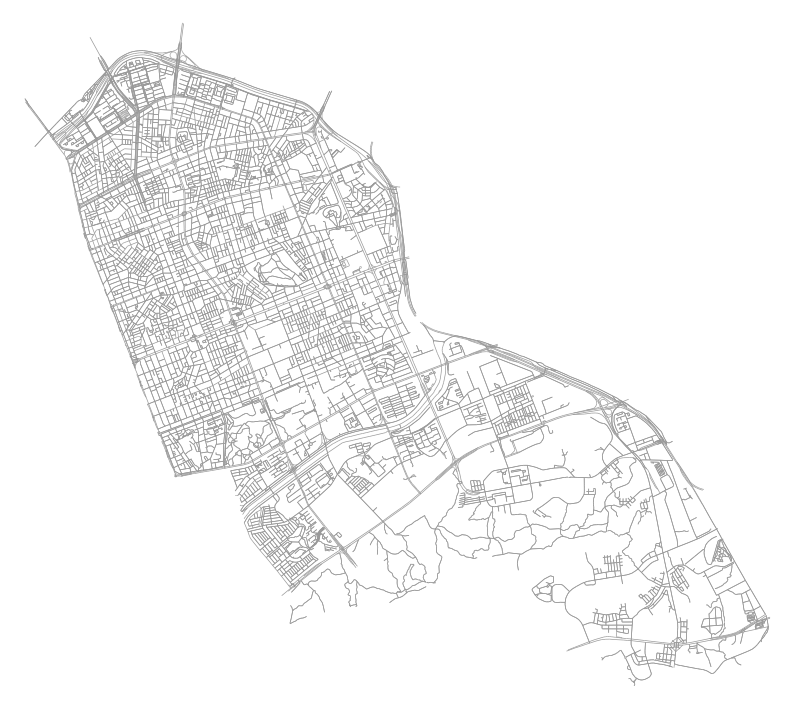

In [5]:
ox.config(log_console=True, use_cache=True)

# get a graph for some city
G = ox.graph_from_place('강남구, 서울시, 대한민국', network_type='all', simplify=False) #,  buffer_dist=200) 

# /data/파일명 폴더 내의 edges/ nodes폴더에 링크와 노트 shp파일이 저장됨
# ox.save_graph_shapefile(G, filepath='./data/osm_road')

fig, ax = ox.plot_graph(G, figsize=(10,10), node_size=0, edge_linewidth=0.5, bgcolor='w')

## 최단경로 분석 

#### 1. 학동역에서 삼성역까지의 최단거리 분석 결과를 시각화해 보십시오

In [7]:
orig_node = ox.nearest_nodes(G, 127.035178, 37.515592) 
dest_node = ox.nearest_nodes(G, 127.062992, 37.508788) 

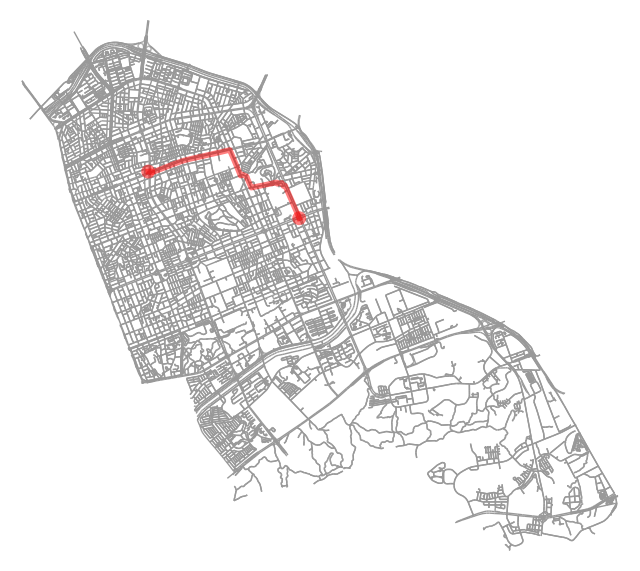

In [8]:
# find the route between these nodes then plot it
route = nx.shortest_path(G, orig_node, dest_node, weight='length')
fig, ax = ox.plot_graph_route(G, route, node_size=0, bgcolor='w' ) #, figsize=(10,10)

## 시간거리 분석

#### 2. 학동역에서 삼성역까지의 최소시간거리 분석 결과를 시각화해 보십시오

In [9]:
# impute missing edge speeds then calculate edge travel times
G = ox.add_edge_speeds(G)
# speed_kph 항목을 만들고 maxspeed 값을 부여. maxspeed가 없는 레코드는 highway(도로 종류)별 평균값을 부여 
G = ox.add_edge_travel_times(G)
# travel_time 항목을 만들고 legth / speed_kph 값을 부여 

c:\Users\LX\AppData\Local\Programs\Python\Python39\lib\site-packages\osmnx\utils_graph.py:85: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  gdf_edges["geometry"] = np.nan


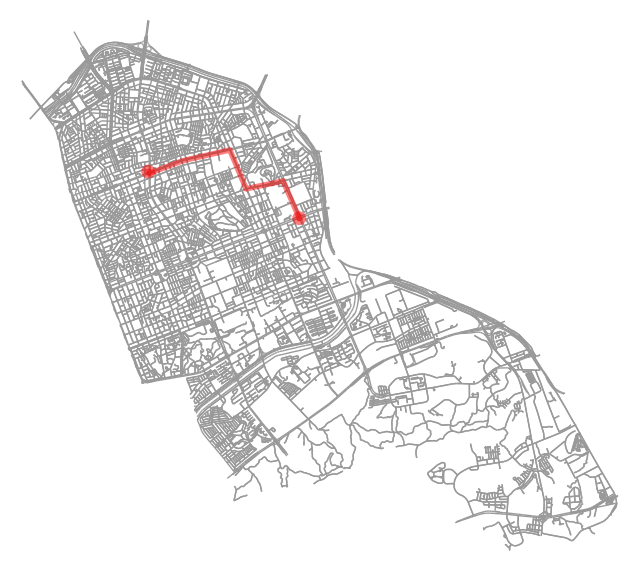

In [10]:
# find the shortest path between these nodes, minimizing travel time, then plot it
route = ox.shortest_path(G, orig_node, dest_node, weight='travel_time')
fig, ax = ox.plot_graph_route(G, route, node_size=0, bgcolor='w')

## 서비스 영역 분석

#### 3. 학동역에서 도보 10분 영역을 시각화해 보십시오

In [12]:
center_node = ox.nearest_nodes(G, 127.035178, 37.515592)  
trip_times = [10]  # 이동 시간 범위
travel_speed = 4 

In [13]:
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [14]:
# make the isochrone polygons 
isochrone_polys1 = []

for trip_time in sorted(trip_times, reverse=True):
    subgraph1 = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    node_points1 = [Point((data['x'], data['y'])) for node, data in subgraph1.nodes(data=True)]
    bounding_poly1 = gpd.GeoSeries(node_points1).unary_union.convex_hull
    isochrone_polys1.append(bounding_poly1)

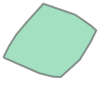

In [15]:
bounding_poly1

In [16]:
isochrone_polys1

[<POLYGON ((127.037 37.51, 127.036 37.511, 127.034 37.511, 127.028 37.513, 12...>]

In [17]:
gdf_poly = gpd.GeoDataFrame(None, geometry=isochrone_polys1, crs="epsg:4326")
gdf_poly.head()

,geometry
0,"POLYGON ((127.03667 37.51045, 127.03552 37.510..."


In [18]:
gdf_poly.explore()

# 3가지 미션을 모두 완료하신 분은 노트북 파일(.ipynb)을 제게 보내주십시오. 